In [15]:
from pyscf import gto, scf
from tools import get_atom_coords, format_for_pyscf, get_atom_list, get_atom_position_list
import pickle

# Load and parse the .xyz file
filename = "CH4.xyz"  # Replace with your .xyz file path
molecular_data = get_atom_coords(filename)


un_correlated_structures = []
# take one frame every 25 frames
# for i in range(0, len(molecular_data), 25):
# take all frames
for i in range(0, len(molecular_data)):
    mol = gto.Mole()
    mol.atom = format_for_pyscf(molecular_data[i])
    mol.basis = '6-31g'
    mol.build()
    un_correlated_structures.append(mol)

# Compute the energy of each structure
density_matrixes = []
for mol in un_correlated_structures:
    mf = scf.RHF(mol)
    mf.kernel()
    density_matrixes.append(mf.make_rdm1())

# form the dataset
data = {'feature':[mol.atom for mol in un_correlated_structures], 'target':density_matrixes}

# save the data
with open('data_full_631g.pkl', 'wb') as f:
    pickle.dump(data, f)

converged SCF energy = -40.1804247851502
converged SCF energy = -40.180485902773
converged SCF energy = -40.1804904062469
converged SCF energy = -40.1804376931617
converged SCF energy = -40.1803288490457
converged SCF energy = -40.1801658867229
converged SCF energy = -40.1799521161784
converged SCF energy = -40.1796920960634
converged SCF energy = -40.1793913085195
converged SCF energy = -40.1790554871682
converged SCF energy = -40.1786917585473
converged SCF energy = -40.1783062555122
converged SCF energy = -40.1779064227487
converged SCF energy = -40.1774989045493
converged SCF energy = -40.1770901612418
converged SCF energy = -40.1766852629896
converged SCF energy = -40.1762902365194
converged SCF energy = -40.1759073821623
converged SCF energy = -40.1755403410112
converged SCF energy = -40.1751885488187
converged SCF energy = -40.1748529883265
converged SCF energy = -40.1745323654618
converged SCF energy = -40.1742208146562
converged SCF energy = -40.1739166416311
converged SCF ene

In [1]:
from pyscf import gto, scf
from tools import get_atom_coords, format_for_pyscf, get_atom_list, get_atom_position_list
import pickle

with open('data_631g.pkl', 'rb') as f:
    data = pickle.load(f)
    
data['target'][0].shape

(17, 17)

In [11]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader

# To load plotly templates for sisl visualization
# import sisl.viz

from e3nn import o3

from graph2mat import (
    BasisConfiguration,
    PointBasis,
    BasisTableWithEdges,
    MatrixDataProcessor,
)
from graph2mat.bindings.torch import TorchBasisMatrixDataset, TorchBasisMatrixData

from graph2mat.bindings.e3nn import E3nnGraph2Mat

from graph2mat.tools.viz import plot_basis_matrix

# The basis 6-31g
hydrogen = PointBasis("H", R=2, basis="2x0e", basis_convention="spherical")
carbon = PointBasis("C", R=5, basis="3x0e + 2x1o", basis_convention="spherical")
basis_list = [hydrogen, carbon]

# The basis table.
table = BasisTableWithEdges([hydrogen, carbon])

# The data processor.
processor = MatrixDataProcessor(
    basis_table=table, symmetric_matrix=True, sub_point_matrix=False
)

In [12]:
def prepare_config(atom_data, density_matrixes):
# def prepare_config(atom_data):
    configs = []
    for i in range(len(atom_data)):
        config = BasisConfiguration(
            point_types = ["C", "H", "H", "H", "H"],
            positions = get_atom_position_list(atom_data[i]),
            basis = basis_list,
            cell=np.eye(3) * 100,
            pbc=(False, False, False),
            matrix = np.array(density_matrixes[i])
        )
        configs.append(config)
    return configs

# configs = prepare_config(data['feature'])
configs = prepare_config(data['feature'], data['target'])

# dataset = TorchBasisMatrixDataset(configs, data_processor=processor)

# data_example = dataset[0]

# loader = DataLoader(dataset, batch_size=10, shuffle=True)

# data_0 = next(iter(loader))

In [13]:
# split the dataset into training and validation
from sklearn.model_selection import train_test_split

train_configs, val_configs = train_test_split(configs, test_size=0.25, random_state=56)

# create the loaders

train_dataset = TorchBasisMatrixDataset(train_configs, data_processor=processor)
val_dataset = TorchBasisMatrixDataset(val_configs, data_processor=processor)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

data_example = train_dataset[0]
data_0 = next(iter(train_loader))

In [14]:
def plot_matrices(data, predictions=None, title="", show=True):
    """Helper function to plot (possibly batched) matrices"""

    matrices = processor.matrix_from_data(data, predictions=predictions)

    if not isinstance(matrices, (tuple, list)):
        matrices = (matrices,)

    for i, (config, matrix) in enumerate(zip(configs, matrices)):
        if show is True or show == i:
            plot_basis_matrix(
                matrix,
                config,
                point_lines={"color": "#123456"},
                basis_lines={"color": "#888888"},
                colorscale="RdBu",
                text=".2f",
                basis_labels=True,
            ).update_layout(title=f"{title} [{i}]", width=600, height=600).show()
            
plot_matrices(data_example, title="Example")

In [6]:
from mace.modules import MACE, RealAgnosticResidualInteractionBlock

num_interactions = 3
hidden_irreps = o3.Irreps("1x0e + 1x1o")

mace_model = MACE(
    r_max=10,
    num_bessel=10,
    num_polynomial_cutoff=10,
    max_ell=2,  # 1,
    interaction_cls=RealAgnosticResidualInteractionBlock,
    interaction_cls_first=RealAgnosticResidualInteractionBlock,
    num_interactions=num_interactions,
    num_elements=2,
    hidden_irreps=hidden_irreps,
    MLP_irreps=o3.Irreps("2x0e"),
    atomic_energies=torch.tensor([0, 0]),
    avg_num_neighbors=2,
    atomic_numbers=[0, 1],
    correlation=2,
    gate=None,
)

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/mace/modules/blocks.py:140: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The

In [7]:
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnEdgeMessageBlock

matrix_mace_model = MatrixMACE(
    mace_model,
    unique_basis=table,
    readout_per_interaction=True,
    edge_hidden_irreps=o3.Irreps("10x0e + 10x1o + 10x2e"),
    preprocessing_edges=E3nnEdgeMessageBlock,
    preprocessing_edges_reuse_nodes=False,
)

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_c

In [ ]:
import torch.optim as optim

# 定义设备：如果有 GPU 则使用 GPU，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将模型移到指定设备
model = matrix_mace_model.to(device)

# The loss function, which we get from graph2mat's metrics functions
from graph2mat import metrics

loss_function = metrics.elementwise_mse

# choose element-wise mean square loss
# loss_function = torch.nn.MSELoss()
# criterion = torch.nn.MSELoss()  # 假设你的输出是连续数值，可以使用均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用 Adam 优化器

In [11]:
from torch.utils.tensorboard import SummaryWriter
import os

# 训练模型
n_steps = 100  # 设置训练的 epoch 数量
# Initialize arrays to store errors
losses = np.zeros(n_steps)
node_rmse = np.zeros(n_steps)
edge_rmse = np.zeros(n_steps)

# Initialize the SummaryWriter
writer = SummaryWriter('runs')
# create the model directory
if not os.path.exists('./models'):
    os.makedirs('./models')

# Loop over the number of steps
for step in range(n_steps):
    model.train()
    for batch in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Make predictions for this batch
        predictions = model(batch)
        
        # Compute the loss
        loss, info = loss_function(
            nodes_pred=predictions['node_labels'],
            nodes_ref=batch.point_labels,
            edges_pred=predictions['edge_labels'],
            edges_ref=batch.edge_labels,
        )

        # Store errors
        losses[step] = loss.item()
        node_rmse[step] = info["node_rmse"]
        edge_rmse[step] = info["edge_rmse"]

        # Log the loss and RMSE to TensorBoard
        writer.add_scalar('Loss/train', loss.item(), step)
        writer.add_scalar('Node RMSE/train', info["node_rmse"], step)
        writer.add_scalar('Edge RMSE/train', info["edge_rmse"], step)

        # Compute gradients
        loss.backward()
        
        # Update weights
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            # Make predictions for this batch
            predictions = model(batch)
            
            # Compute the loss
            loss, info = loss_function(
                nodes_pred=predictions['node_labels'],
                nodes_ref=batch.point_labels,
                edges_pred=predictions['edge_labels'],
                edges_ref=batch.edge_labels,
            )

            # Log the validation loss and RMSE to TensorBoard
            writer.add_scalar('Loss/val', loss.item(), step)
            writer.add_scalar('Node RMSE/val', info["node_rmse"], step)
            writer.add_scalar('Edge RMSE/val', info["edge_rmse"], step)

    print(f"Step {step + 1}/{n_steps}, Train Loss: {losses[step]}, Train Node RMSE: {node_rmse[step]}, Train Edge RMSE: {edge_rmse[step]}")
    
    # save the model every 20 steps
    if (step + 1) % 20 == 0:
        torch.save(model.state_dict(), f"./models/model_{step + 1}.pt")

# Close the writer
writer.close()

Step 1/100, Train Loss: 0.04505802318453789, Train Node RMSE: 0.2674102783203125, Train Edge RMSE: 0.09707562625408173
Step 2/100, Train Loss: 0.044495053589344025, Train Node RMSE: 0.265582412481308, Train Edge RMSE: 0.09702984243631363
Step 3/100, Train Loss: 0.04387690871953964, Train Node RMSE: 0.2635928988456726, Train Edge RMSE: 0.0968618094921112
Step 4/100, Train Loss: 0.04288320988416672, Train Node RMSE: 0.26049187779426575, Train Edge RMSE: 0.0961211770772934
Step 5/100, Train Loss: 0.04175117611885071, Train Node RMSE: 0.25676482915878296, Train Edge RMSE: 0.09580910950899124
Step 6/100, Train Loss: 0.04052281007170677, Train Node RMSE: 0.2525544762611389, Train Edge RMSE: 0.09583917260169983
Step 7/100, Train Loss: 0.04021540284156799, Train Node RMSE: 0.2516549229621887, Train Edge RMSE: 0.09526093304157257
Step 8/100, Train Loss: 0.03950724005699158, Train Node RMSE: 0.24932865798473358, Train Edge RMSE: 0.09477602690458298
Step 9/100, Train Loss: 0.03920884430408478, Tr

In [ ]:
import tensorboard

In [ ]:
print(torch.__version__)

2.2.2


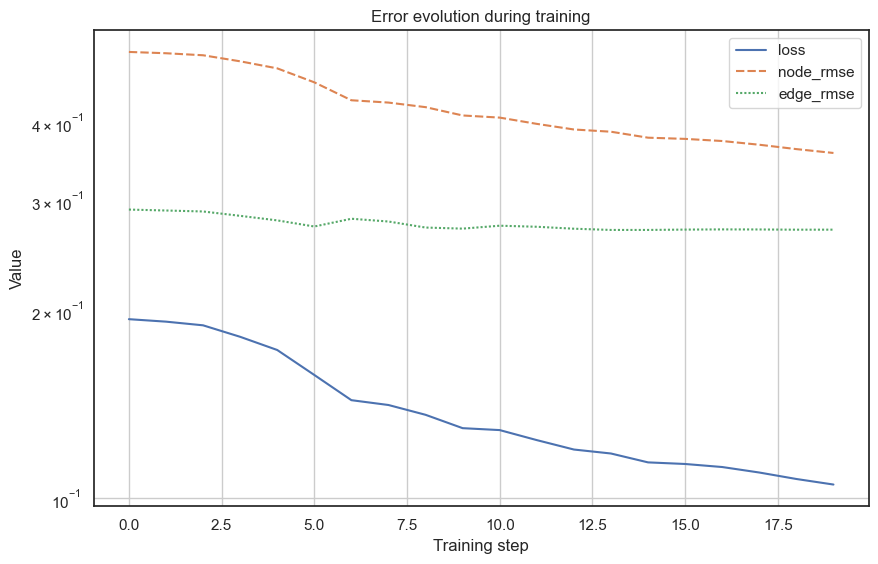

In [94]:
import pandas as pd

df = pd.DataFrame(
    np.array([losses, node_rmse, edge_rmse]).T,
    columns=["loss", "node_rmse", "edge_rmse"],
)

# df.plot(backend="plotly").update_layout(
#     yaxis_type="log", yaxis_showgrid=True, xaxis_showgrid=True
# ).update_layout(
#     yaxis_title="Value",
#     xaxis_title="Training step",
#     title="Error evolution during training",
# )

# plot the decrease of these errors with a beutiful seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("white")
plt.figure(figsize=(10, 6.18))
sns.lineplot(data=df)
plt.yscale("log")
plt.grid()
plt.xlabel("Training step")
plt.ylabel("Value")
plt.title("Error evolution during training")
plt.show()

In [12]:
predictions = model(data_0)

plot_matrices(data_0, title=f"Target matrix", show=0)
plot_matrices(
    data_0,
    predictions={
        "node_labels": predictions['node_labels'],
        "edge_labels": predictions['edge_labels'],
    },
    title=f"Prediction after {n_steps} training steps",
    show=0,
)

dep:0: SislDeprecation:

specie is deprecated, use species instead. [>=0.15] [removed in 0.16]



In [83]:
# Load the model state dictionary

new_model = MatrixMACE(
    mace_model,
    unique_basis=table,
    readout_per_interaction=True,
    edge_hidden_irreps=o3.Irreps("10x0e + 10x1o + 10x2e"),
    preprocessing_edges=E3nnEdgeMessageBlock,
    preprocessing_edges_reuse_nodes=False,
)

new_model.load_state_dict(torch.load('trained_model.pth'))

# Set the model to evaluation mode
new_model.eval()

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_c

MatrixMACE(
  (mace): MACE(
    (node_embedding): LinearNodeEmbeddingBlock(
      (linear): Linear(2x0e -> 1x0e | 2 weights)
    )
    (radial_embedding): RadialEmbeddingBlock(
      (bessel_fn): BesselBasis(r_max=10.0, num_basis=10, trainable=False)
      (cutoff_fn): PolynomialCutoff(p=10.0, r_max=10.0)
    )
    (spherical_harmonics): SphericalHarmonics()
    (atomic_energies_fn): AtomicEnergiesBlock(energies=[0.0000, 0.0000])
    (interactions): ModuleList(
      (0): RealAgnosticResidualInteractionBlock(
        (linear_up): Linear(1x0e -> 1x0e | 1 weights)
        (conv_tp): TensorProduct(1x0e x 1x0e+1x1o+1x2e -> 1x0e+1x1o+1x2e | 3 paths | 3 weights)
        (conv_tp_weights): FullyConnectedNet[10, 64, 64, 64, 3]
        (linear): Linear(1x0e+1x1o+1x2e -> 1x0e+1x1o+1x2e | 3 weights)
        (skip_tp): FullyConnectedTensorProduct(1x0e x 2x0e -> 1x0e+1x1o | 2 paths | 2 weights)
        (reshape): reshape_irreps()
      )
      (1): RealAgnosticResidualInteractionBlock(
        (lin

In [84]:
new_model(data_0)

{'energy': tensor([1.1492, 1.1708, 1.2230, 1.1503, 1.2012, 1.1794, 1.1517, 1.2087, 1.2078,
         1.2209], grad_fn=<SumBackward1>),
 'node_energy': tensor([0.6966, 0.1182, 0.1142, 0.1118, 0.1085, 0.7097, 0.1149, 0.1156, 0.1143,
         0.1164, 0.7439, 0.1223, 0.1210, 0.1210, 0.1148, 0.6972, 0.1098, 0.1128,
         0.1129, 0.1176, 0.7292, 0.1205, 0.1189, 0.1181, 0.1144, 0.7151, 0.1179,
         0.1166, 0.1147, 0.1150, 0.6981, 0.1126, 0.1119, 0.1116, 0.1176, 0.7342,
         0.1165, 0.1182, 0.1195, 0.1204, 0.7337, 0.1146, 0.1184, 0.1184, 0.1228,
         0.7425, 0.1234, 0.1209, 0.1197, 0.1143], grad_fn=<SumBackward1>),
 'contributions': tensor([[ 0.0000,  0.0000,  2.5538, -0.5848, -0.8197],
         [ 0.0000,  0.0000,  2.6121, -0.5890, -0.8522],
         [ 0.0000,  0.0000,  2.7498, -0.5933, -0.9335],
         [ 0.0000,  0.0000,  2.5568, -0.5852, -0.8213],
         [ 0.0000,  0.0000,  2.6923, -0.5922, -0.8989],
         [ 0.0000,  0.0000,  2.6348, -0.5901, -0.8652],
         [ 0.0000,